# CNN.
## Saliency map visualization

[What is saliency map?](https://en.wikipedia.org/wiki/Saliency_map)

In [1]:
!pip install matplotlib==3.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import json
import requests

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F

In [4]:
torch.manual_seed(12345)
np.random.seed(12345)

device = torch.device("cuda:0") if torch.cuda.is_available() else \
         torch.device("mps") if torch.backends.mps.is_available() else \
         torch.device("cpu")

geom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
])
post_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

model = torchvision.models.resnet18(
    weights=torchvision.models.resnet.ResNet18_Weights.IMAGENET1K_V1
)
model.to(device).eval();

In [5]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"current device: {device}")

torch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118
current device: cuda:0


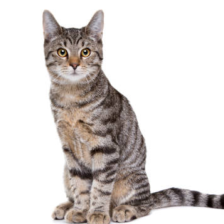

In [6]:
image_url = "https://media.istockphoto.com/photos/european-short-haired-cat-picture-id1072769156?k=20&m=1072769156&s=612x612&w=0&h=k6eFXtE7bpEmR2ns5p3qe_KYh098CVLMz4iKm5OuO6Y="

image_raw = Image.open(requests.get(image_url, stream=True).raw)
image = geom_transforms(image_raw)
image

# Visualization of the input image gradients

In [7]:
# download idx2class mapping

idx2class_url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
idx2class = eval(requests.get(idx2class_url).content)

In [8]:
tensor_input = post_transforms(image)[None].to(device)  # [1, 3, 256, 256]
tensor_input.requires_grad_()

output = torch.softmax(model(tensor_input), -1)

argmax_idx = output.argmax()
max_out = output[0, argmax_idx]

print(f"Argmax idx is {argmax_idx}, and it's ",
      f"corresponding class is {idx2class[argmax_idx.item()]}")
print(f"Output prob is for this clas is {max_out.item()}")

max_out.backward()

Argmax idx is 281, and it's  corresponding class is tabby, tabby cat
Output prob is for this clas is 0.6496105790138245


In [9]:
saliency, _ = torch.max(tensor_input.grad.data.abs(), 1)

In [10]:
def denormalize(x):
    mean = np.array([0.485, 0.456, 0.406])[None, None]
    std = np.array([0.229, 0.224, 0.225])[None, None]
    return (x * std) + mean

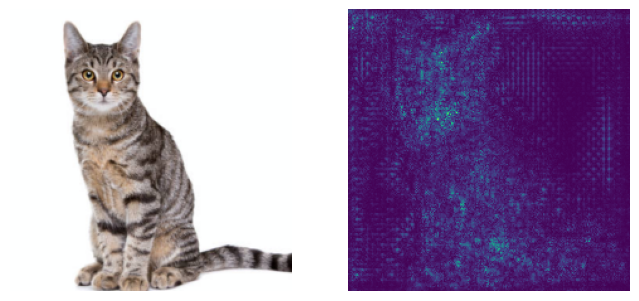

In [11]:
_, ax = plt.subplots(1, 2, figsize=(8, 16))
ax = ax.flatten()

ax[0].imshow((denormalize(tensor_input.detach().cpu().numpy()[0].transpose(1, 2, 0)) * 255).astype(np.uint8))
ax[0].axis("off")
ax[1].imshow(saliency[0].cpu())
ax[1].axis("off")

plt.show()

In [12]:
grad = tensor_input.grad.data.cpu().clone()
inp = tensor_input.detach().clone()

In [13]:
h = 0.01
tensor_input_more_conf = inp.clone()
tensor_input_more_conf[(grad > 0)] = tensor_input_more_conf[(grad > 0)] + h 
tensor_input_more_conf[(grad < 0)] = tensor_input_more_conf[(grad < 0)] - h

In [14]:
cur_output = torch.softmax(model(tensor_input_more_conf), -1)

cur_argmax_idx = cur_output.argmax()
cur_max_out = cur_output[0, cur_argmax_idx]

print("Statistics for original image")
print(f"{idx2class[argmax_idx.item()]} class with {max_out} prob")
print("Statistics for more confident image")
print(f"{idx2class[cur_argmax_idx.item()]} class with {cur_max_out} prob")

Statistics for original image
tabby, tabby cat class with 0.6496105790138245 prob
Statistics for more confident image
tabby, tabby cat class with 0.8769049048423767 prob


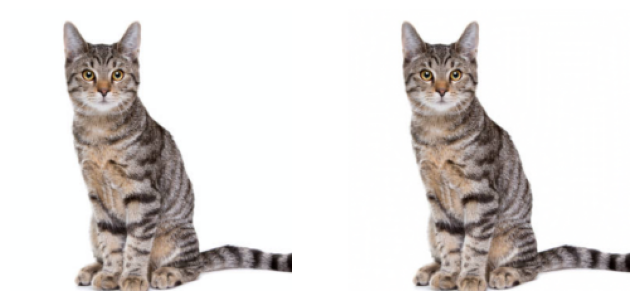

In [15]:
_, ax = plt.subplots(1, 2, figsize=(8, 16))
ax = ax.flatten()

ax[0].imshow((denormalize(tensor_input.detach().cpu().numpy()[0].transpose(1, 2, 0)) * 255).astype(np.uint8))
ax[0].axis("off")
ax[1].imshow((denormalize(tensor_input_more_conf.detach().cpu().numpy()[0].transpose(1, 2, 0)) * 255).astype(np.uint8))
ax[1].axis("off")

plt.show()

In [16]:
h = 0.01
tensor_input_less_conf = inp.clone()
tensor_input_less_conf[(grad < 0)] = tensor_input_less_conf[(grad < 0)] + h
tensor_input_less_conf[(grad > 0)] = tensor_input_less_conf[(grad > 0)] - h

In [17]:
cur_output = torch.softmax(model(tensor_input_less_conf), -1)

cur_argmax_idx = cur_output.argmax()
cur_max_out = cur_output[0, cur_argmax_idx]

print("Statistics for original image")
print(f"{idx2class[argmax_idx.item()]} class with {max_out} prob")
print("Statistics for less confident image")
print(f"{idx2class[cur_argmax_idx.item()]} class with {cur_max_out} prob")
print(f"(It is {cur_output[0, argmax_idx]} for original class)")

Statistics for original image
tabby, tabby cat class with 0.6496105790138245 prob
Statistics for less confident image
Egyptian cat class with 0.7934609651565552 prob
(It is 0.13945254683494568 for original class)


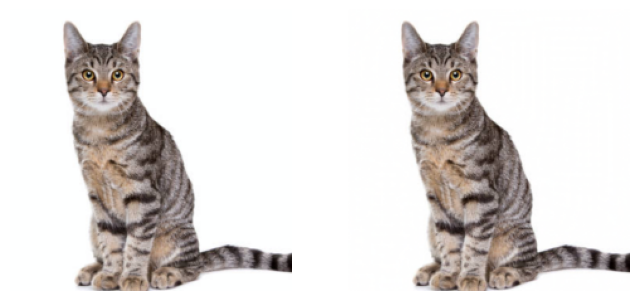

In [18]:
_, ax = plt.subplots(1, 2, figsize=(8, 16))
ax = ax.flatten()

ax[0].imshow((denormalize(tensor_input.detach().cpu().numpy()[0].transpose(1, 2, 0)) * 255).astype(np.uint8))
ax[0].axis("off")
ax[1].imshow((denormalize(tensor_input_less_conf.detach().cpu().numpy()[0].transpose(1, 2, 0)) * 255).astype(np.uint8))
ax[1].axis("off")

plt.show()

## Model interpretability
### Captum

[github](https://github.com/pytorch/captum)

In [19]:
!pip install captum==0.5.0 --quiet

In [20]:
from matplotlib.colors import LinearSegmentedColormap

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [21]:
# MPS doesn't support float64 yet, need to go to the cpu
if device.type == "mps":
    device = "cpu"
    model.to(device)

In [22]:
image_raw = Image.open(requests.get(image_url, stream=True).raw)
image = geom_transforms(image_raw)
tensor_input = post_transforms(image)[None].to(device)  # [1, 3, 256, 256]

In [23]:
output = model(tensor_input)
output = torch.softmax(output, dim=1)

prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx2class[pred_label_idx.item()]

print(f"Predicted: {predicted_label} ({prediction_score.squeeze().item():.5f})")

Predicted: tabby, tabby cat (0.64961)


#### Integrated gradients
[link](https://arxiv.org/abs/1703.01365)

In [24]:
# IntegratedGradients?

In [25]:
integrated_gradients = IntegratedGradients(model)

In [26]:
# integrated_gradients.attribute?

In [28]:
attributions_ig = integrated_gradients.attribute(
    tensor_input,
    target=pred_label_idx,
    n_steps=200
)

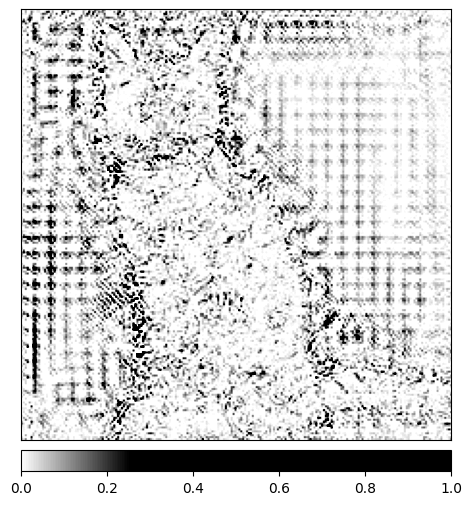

In [29]:
default_cmap = LinearSegmentedColormap.from_list(
    "custom blue", 
    [(0, "#ffffff"),
    (0.25, "#000000"),
    (1, "#000000")], N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(tensor_input.detach().squeeze().cpu().detach().numpy(), (1,2,0)),
    method="heat_map",
    cmap=default_cmap,
    show_colorbar=True,
    sign="positive",
    outlier_perc=1
)

#### Noise Tunnel

In [30]:
# NoiseTunnel?

In [31]:
noise_tunnel = NoiseTunnel(integrated_gradients)

In [32]:
attributions_ig_nt = noise_tunnel.attribute(
    tensor_input,
    nt_samples=10,
    nt_type="smoothgrad_sq",
    target=pred_label_idx
)

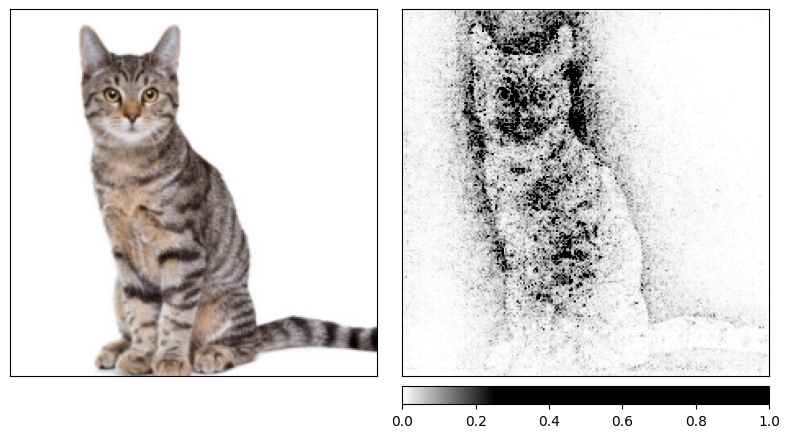

In [33]:
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.array(image),
    ["original_image", "heat_map"],
    ["all", "positive"],
    cmap=default_cmap,
    show_colorbar=True)

#### GradientShap

In [34]:
# GradientShap?

In [35]:
gradient_shap = GradientShap(model)

In [36]:
# Defining baseline distribution of images
rand_img_dist = torch.cat([tensor_input * 0, tensor_input * 1])

attributions_gs = gradient_shap.attribute(
    tensor_input,
    n_samples=50,
    stdevs=0.0001,
    baselines=rand_img_dist,
    target=pred_label_idx
)

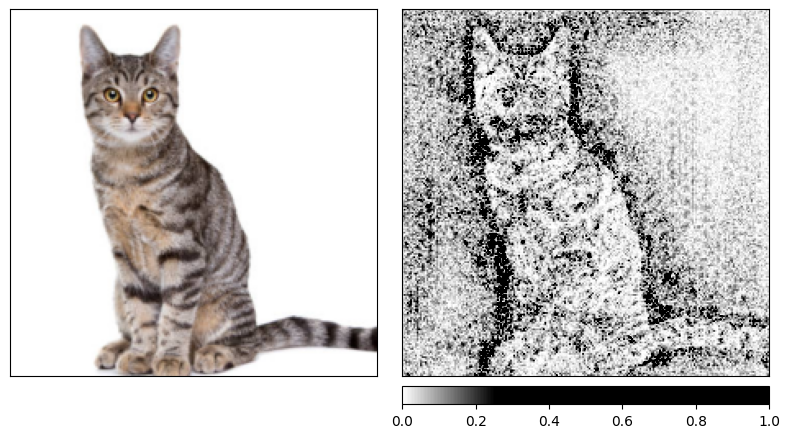

In [37]:
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.array(image),
    ["original_image", "heat_map"],
    ["all", "absolute_value"],
    cmap=default_cmap,
    show_colorbar=True)

---

### Hooks

In [38]:
# nn.Module
# backward
# hook(module: nn.Module, grad_input: torch.Tensor, grad_output: torch.Tensor) -> Tensor or None
# forward
# hook(module: nn.Moduel, input: torch.Tensor, output: torch.Tensor) -> None

# torch.Tensor  - only backward
# hook(grad: torch.Tensor) -> Tensor or None

In [42]:
device = 'cpu'
model = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights.IMAGENET1K_V1).eval().to(device)
image_url = "https://media.istockphoto.com/photos/european-short-haired-cat-picture-id1072769156?k=20&m=1072769156&s=612x612&w=0&h=k6eFXtE7bpEmR2ns5p3qe_KYh098CVLMz4iKm5OuO6Y="

image_raw = Image.open(requests.get(image_url, stream=True).raw)
image = geom_transforms(image_raw)

tensor = post_transforms(image).unsqueeze(0).requires_grad_()

In [40]:
from torch import nn


class GuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None
        self.activation_maps = []
        self.model.eval()
        self.register_hooks()
    
    def register_hooks(self):
        def first_layer_hook_fn(module, grad_in, grad_out):
            self.image_reconstruction = grad_in[0]

        def forward_hook_fn(module, input, output):
            self.activation_maps.append(output)

        def backward_hook_fn(module, grad_in, grad_out):
            grad = self.activation_maps.pop()
            
            # for the forward pass, after the ReLU operation,
            # if the output value is positive, we set the value to 1,
            # and if the output value is negative, we set it to 0.
            grad[grad > 0] = 1

            # grad_out[0] stores the gradients for each feature map,
            # and we only retain the positive gradients
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)
            new_grad_in = positive_grad_out * grad

            return (new_grad_in,)

        
        modules = list(self.model.features.named_children())
        for _, module in modules:
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)
        
        first_layer = modules[0][1]
        first_layer.register_backward_hook(first_layer_hook_fn)

    @staticmethod
    def normalize(image):
        norm = (image - image.mean()) / image.std()
        norm = norm * 0.1
        norm = norm + 0.5
        norm = norm.clip(0, 1)
        return norm
    
    def visualize(self, input_image, target_class):
        input_image
        model_output = self.model(input_image)
        self.model.zero_grad()
        pred_class = model_output.argmax().item()

        grad_target_map = torch.zeros(model_output.shape, dtype=torch.float)
        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred_class] = 1


        model_output.backward(grad_target_map)

        result = self.image_reconstruction.data[0].permute(1, 2, 0)
        return self.normalize(result.numpy())

In [43]:
gbp = GuidedBackprop(model)

result = gbp.visualize(tensor, None)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


---

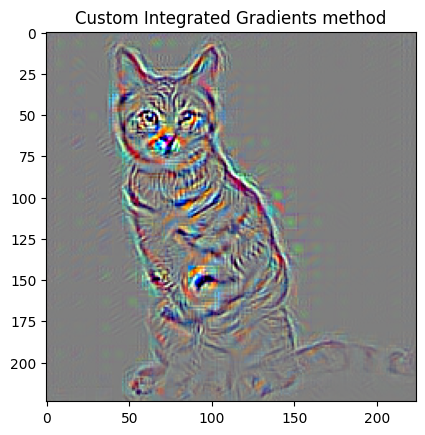

In [44]:
plt.imshow(GuidedBackprop.normalize(result))

plt.title("Custom Integrated Gradients method")
plt.show()